# Практическое задание

## Урок 3. Связь бизнес-показателей и DS-метрик

### Домашнее задание

1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
4. сделать выводы о том, какая модель справилась с задачей лучше других
5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого). 

p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно). 
Допустим, у нас две модели:

- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90

Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

$$ *** $$ 

### Кейс 2 - определение ССЗ

В рамках конкурса вам нужно предсказать наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра. Датасет сформирован из 100.000 реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:

 

Объективные признаки:

 - Возраст
 - Рост
 - Вес
 - Пол
 

Результаты измерения:

 - Артериальное давление верхнее и нижнее
 - Холестерин
 - Глюкоза
 

Субъективные признаки:

 - Курение
 - Употребление Алкоголя
 - Физическая активность
 

Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

Таргет - наличие сердечно-сосудистых заболеваний (ССЗ)

$$ *** $$

### 1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта

### 2. при обучении моделей обязательно использовать кроссвалидацию

In [1]:
import pandas as pd # ok
import numpy as np # ok
 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.feature_extraction.text import TfidfVectorizer # ok
from sklearn.linear_model import LogisticRegression # ok
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV # ok
from scipy.sparse import hstack 
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier # cслучайный лес, градиентный бустинг 

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import FeatureUnion

In [2]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [3]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

In [4]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

In [5]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

In [6]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])


In [7]:
#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7867401104915408+-0.00852135511666111


In [8]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.386937, F-Score=0.730, Precision=0.647, Recall=0.838


In [9]:
def roc_auc_plot(y_test, y_score):
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
    plt.show()

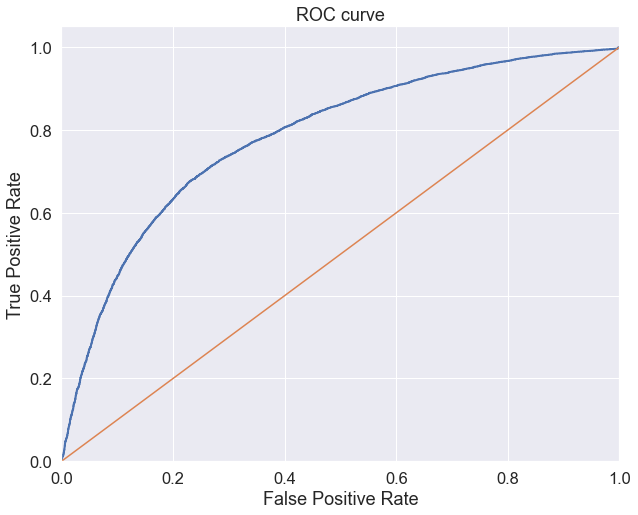

In [10]:
roc_auc_plot(y_test, y_score)

In [11]:
from sklearn.metrics import roc_auc_score, log_loss

#Ваш код здесь
roc_auc_score_log_reg = roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])


print(f"roc auc score log reg: {roc_auc_score_log_reg}")

print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])))

roc auc score log reg: 0.7840347790421852
log loss score: 0.5779604008230665


In [12]:
# определим списки в которые будем помещать метрики разных моделей 


list_headlines = ['precision', 'recall', 'auc', 'f_score'] # столбцы
list_index = ['Logistic_Regression', 'Gradient_Boosting_Classifier', 'Random_Forest_Classifier'] # модели


list_log_reg = []
list_gradient_boosting = []
list_random_forest = []

In [13]:
# добавим данные модели, полученной с помощью LogisticRegression
list_log_reg.append(precision[ix])
list_log_reg.append(recall[ix])
list_log_reg.append(roc_auc_score_log_reg)
list_log_reg.append(fscore[ix])

## GradientBoostingClassifier

In [14]:
%%time
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
classifier_gradient_boosting = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier_gradient_boosting, X_train, y_train, cv=6, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier_gradient_boosting.fit(X_train, y_train)
y_score_gradient_boosting = classifier_gradient_boosting.predict_proba(X_test)[:, 1]

CV score is 0.8023377962657184+-0.004150757612691979
CPU times: total: 25.8 s
Wall time: 26 s


In [15]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score_gradient_boosting)
fscore_gradient_boosting = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix_gradient_boosting= np.argmax(fscore_gradient_boosting)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix_gradient_boosting], 
                                                                        fscore[ix_gradient_boosting],
                                                                        precision[ix_gradient_boosting],
                                                                        recall[ix_gradient_boosting]))

Best Threshold=0.394947, F-Score=0.726, Precision=0.698, Recall=0.788


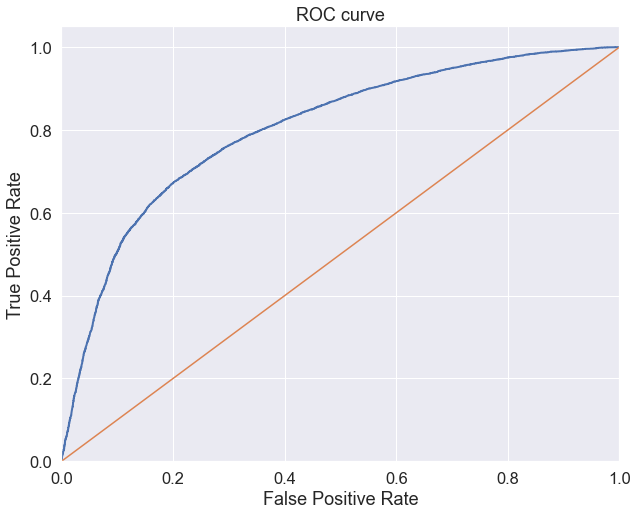

In [16]:
roc_auc_plot(y_test, y_score_gradient_boosting)

In [17]:
roc_auc_score_gradient_boosting = roc_auc_score(y_true=y_test, y_score=classifier_gradient_boosting.predict_proba(X_test)[:,1])
print(f"roc auc score: {roc_auc_score_gradient_boosting}")
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier_gradient_boosting.predict_proba(X_test)[:,1])))

roc auc score: 0.8026161609036856
log loss score: 0.5397443665269267


In [18]:
# добавим данные модели, полученной с помощью GradientBoostingClassifier
list_gradient_boosting.append(precision[ix_gradient_boosting])
list_gradient_boosting.append(recall[ix_gradient_boosting])
list_gradient_boosting.append(roc_auc_score_gradient_boosting)
list_gradient_boosting.append(fscore[ix_gradient_boosting])

## RandomForestClassifier

In [19]:
%%time
classifier_random_forest = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier_random_forest, X_train, y_train, cv=6, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier_random_forest.fit(X_train, y_train)
y_score_random_forest = classifier_random_forest.predict_proba(X_test)[:, 1]

CV score is 0.775500216390547+-0.002836899882861481
CPU times: total: 31.8 s
Wall time: 31.9 s


In [20]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score_random_forest)
fscore_random_forest = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix_random_forest = np.argmax(fscore_random_forest)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix_random_forest], 
                                                                        fscore[ix_random_forest],
                                                                        precision[ix_random_forest],
                                                                        recall[ix_random_forest]))

Best Threshold=0.350000, F-Score=0.663, Precision=0.643, Recall=0.816


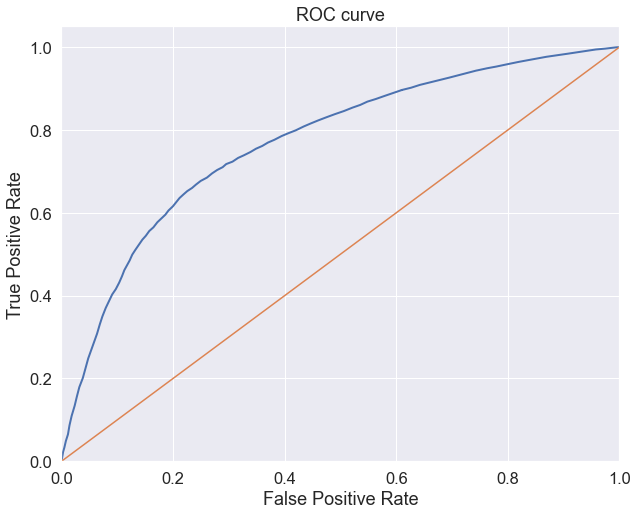

In [21]:
roc_auc_plot(y_test, y_score_random_forest)

In [22]:
roc_auc_score_random_forest = roc_auc_score(y_true=y_test, y_score=classifier_random_forest.predict_proba(X_test)[:,1])
print(f"roc auc score: {roc_auc_score_random_forest}")
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier_random_forest.predict_proba(X_test)[:,1])))


roc auc score: 0.7710366181802983
log loss score: 0.5992984853728378


In [23]:
# добавим данные модели, полученной с помощью GradientBoostingClassifier
list_random_forest.append(precision[ix_random_forest])
list_random_forest.append(recall[ix_random_forest])
list_random_forest.append(roc_auc_score_random_forest)
list_random_forest.append(fscore[ix_random_forest])

### 3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)

In [24]:
list_pivot = []

list_pivot.append(list_log_reg)
list_pivot.append(list_gradient_boosting)
list_pivot.append(list_random_forest)

metrics_pivot = pd.DataFrame(list_pivot, columns=list_headlines, index=list_index)
metrics_pivot

,precision,recall,auc,f_score
Logistic_Regression,0.647431,0.837558,0.784035,0.730323
Gradient_Boosting_Classifier,0.697848,0.788134,0.802616,0.725775
Random_Forest_Classifier,0.642669,0.815553,0.771037,0.662859


### 4. сделать выводы о том, какая модель справилась с задачей лучше других

При предсказании заболеваний, одной из объективных метрик качества модели является recall (полнота). Среди рассмотернных моделей - Logistic_Regression и Random_Forest_Classifier справились лучше с задачей по данной метрике (0,84 и 0,82 соотвественно)

### 5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого).
### p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:
### Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно). 
### Допустим, у нас две модели:
### - первая помечает 100 объектов как класс 1, но TP = 90
### - вторая помечает 1000 объектов как класс 1, но TP такой же - 90
### Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

Первая модель лучше, потому что у нее меньше ложных срабатываний (меньше FN).

При сильном дисбалансе классов стоит цель - более точно определить объекты, относящиеся к классу 1 (TP), чем к классу 0 (TN). 
Использование метрики roc_auc_curve при сравнении представленных моделей не является целесообразным по причине сильной завимости метрики от количества ложных срабатываний (FN). При построении графика roc auc curve формируется две оси - TPR (True Positive Rate) и FPR (False Positive Rate). В случае с первой моделью TPR равен 0,9, и площадь под кривой выше по сравнению со второй моделью, где площадь под кривой меньше за счет низкого TPR (0,09). Метрика roc_auc_curve чувствительна к количеству ложных срабатываний (FN) при дисбалансе классов, несмотря на одинаковое значение TP в двух представленных моделях.
Так как точность определения класса 0 (TN) интересует в меньшей степени, отптимальной является метрика precision_recall_curve, которая не чувствительна к истинно негативным результатам (TN), так как при расчете precision (точности) и recall (полноты) не используется TN. 

Таким образом, рациональной метрикой оценки качества моделей при несбалансированных классах является precision_recall_curve